In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Defining a class for the integrators

In [87]:
class Scheme:
    def __init__(self, step_funtion, force, potential):
        self.step_function = step_funtion
        self.force = force
        self.potential = potential

    def run_simulation(q_init,p_init, Nsteps, h, gamma, step_function, force_function):
        beta = 1
        q_traj = [np.copy(q_init)]
        p_traj = [np.copy(p_init)]
        t_traj = [0]

        q = np.copy(q0)
        p = np.copy(p0)
        t = 0

        for n in range(Nsteps):
            q,p = self.step_function(q, p, h, gamma, beta, self.force)
            t = t + h

            q_traj += [q]
            p_traj += [p]
            t_traj += [t]

        q_traj = np.array(q_traj)
        p_traj = np.array(p_traj)
        t_traj = np.array(t_traj)

        return q_traj, p_traj, t_traj

    def simulate_trajectories(self, n_steps, stepsize, q_init, p_init, gammas):
        trajectories = []
        for gamma in gammas:
            q_traj, p_traj, t_traj = run_simulation(q0, p0, Nsteps , h, gamma, 1, self.step_function, self.force)
            trajectories.append((q_traj, p_traj, t_traj))
        return gammas, trajectories

    def friction_graph(self, n_steps, stepsize, sims,gammas, q_init = None, p_init = None):
        if q_init == None:
            q_init = np.zeros(sims)
        if p_init == None:
            p_init = np.zeros(sims)
        gammas, trajectories = self.simulate_trajectories(n_steps, stepsize, q_init, p_init, gammas)
        fig = plt.figure(figsize=[15,10])
        print(len(trajectories))
        for i in range(len(trajectories)):
            q_traj, _,_ = trajectories[i]
            histogram,bins = np.histogram(q_traj,bins=50,range=[-3,3], density=True)
            midx = (bins[0:-1]+bins[1:])/2
            plt.plot(midx,histogram,label=f'Friction = {gammas[i]}')
            plt.xlabel('$q$')
            plt.ylabel('Density')
            plt.legend()

        plt.title("Distribution of $q$ for different values of friction")
        rho = np.exp( -self.potential(midx))
        rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) )
        plt.plot(midx,rho,'--',label='Truth')

# Defining functions for OBABA

In [88]:
def force_1(q):
    F = q - q**3
    return F

In [89]:
def A_step( qp , h ):
    q,p = qp

    q = q + h*p

    return [q,p]

def B_step( qp , h, force ):
    q,p = qp

    F = force(q)

    p = p + h*F

    return [q,p]

def O_step( qp , h,gamma, beta ):
    q,p = qp

    alpha = np.exp(-h*gamma)

    R = np.random.randn( q.size ).reshape( q.shape)
    p = np.exp(- gamma*h )*p+ np.sqrt(1/beta)*np.sqrt(1-np.exp(-2*gamma*h))*R

    return [q,p]

In [90]:
def obabo_step(q,p,h,gamma,beta,force):

    # The algorithm "ABO" does A then B then O

    qp = [q,p]  #this just translates the separate q and p vectors
                #into a single vector composed from the pair.

    qp = O_step( qp, h, gamma, beta )
    qp = B_step( qp, h, force)
    qp = A_step(qp , h )
    qp = B_step( qp, h, force)
    qp = O_step( qp, h, gamma, beta )


    q,p = qp

    return q , p

In [91]:
def U(x):
    return - x**2/2 + x**4/4

# Graphing the results of the simulation

In [92]:
OBABO = Scheme(obabo_step, force_1, U)

In [93]:
gammas = [10**p for p in range(-5,2)]

7


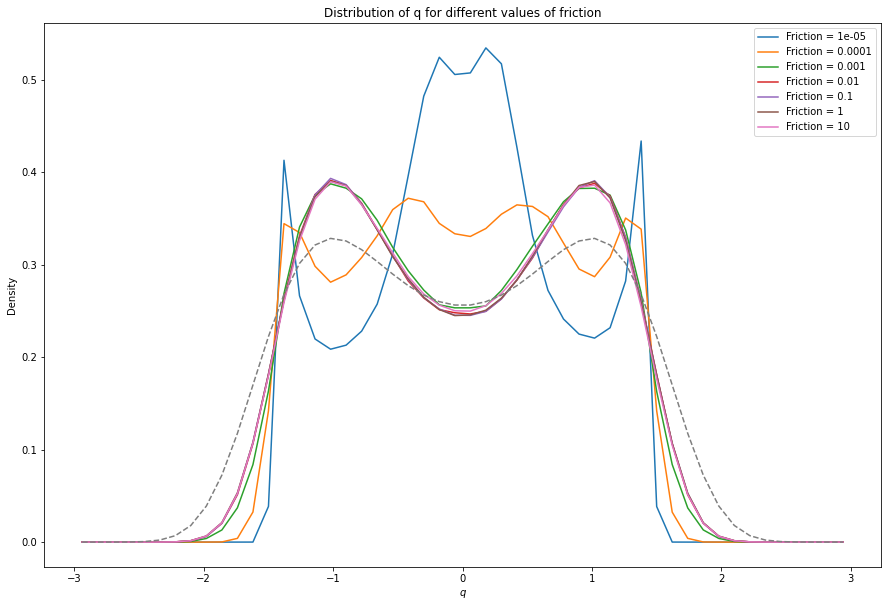

In [94]:
OBABO.friction_graph(1000, 0.1, 1000, gammas)